# Домашняя работа: "Методы оптимизации"

ФИО: Лыжин Роман Денисович

## Описание задания:
Вам необходимо реализовать оставшиеся методы оптимизации, которые разбирались на лекции: <b>Momentum, AdaDelta, Adam</b>. Сравнение методов оптимизации нужно провести на примере из семинара, а также при обучении сверточной нейронной сети на датасете MNIST.



## Задание разделено на следующие части:
1.1 Реализация методов Momentum, AdaDelta, Adam **(1 балл)**

1.2 Сравнение реализованных методов **(1 балл)**

2.1 Реализация сверточной нейронной сети и обучение ее на MNIST **(2 балла)**

2.2 Сравнение графиков обучения для нейросети на реализованных методах **(1 балл)**

## Срок выполнения задания:
Данное задание можно сдать без штрафов до 10 октября.

In [ ]:
from functools import partial

import numpy as np
import torch
from tqdm.auto import tqdm
from torch import nn
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.pyplot import cm
from matplotlib.colors import LogNorm
from matplotlib import animation
from mpl_toolkits import mplot3d
from matplotlib.gridspec import GridSpec
from torchvision import datasets, transforms
from IPython.display import HTML
%matplotlib inline
plt.rc('animation', html='html5')

## Часть 1: Реализация методов

In [ ]:
# https://github.com/dzlab/deepprojects/blob/master/visualization/Optimizers_in_Action.ipynb

def grid_samples(center=[0, 0], offset=5, size=100):
    range1 = np.linspace(center[0]-offset, center[0]+offset, size)
    range2 = np.linspace(center[1]-offset, center[1]+offset, size)
    return torch.from_numpy(np.stack(np.meshgrid(range1, range2))).float()


def mse(y, y_hat):
    return ((y - y_hat) ** 2).mean(axis=-1)


def msre(y, y_hat):
    return ((y - y_hat) ** 2).mean(axis=-1).sqrt()


def mae(y, y_hat):
    return ((y - y_hat).abs()).mean(axis=-1)


class LossAnimator:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.size = len(X)

    def loss_func(self, W, loss):
        shape = W.shape
        return loss((self.X @ W.view(shape[0], -1)).T, self.y).view(shape[1:])

    def plot_loss_funcs(self, weights, fcts, titles, view=(20, 50)):
        num_fcts = len(fcts)
        fig = plt.figure(figsize=(7 * num_fcts,7))
        for i in range(num_fcts):
            loss = self.loss_func(weights, loss=fcts[i])
            ax = fig.add_subplot(1, num_fcts, i+1, projection='3d')
            ax.plot_surface(*weights, loss, cmap='viridis')
            ax.set_xlabel('w0'); ax.set_ylabel('w1'); ax.set_zlabel('Loss')
            ax.set_title(titles[i])
            ax.view_init(*view)

    def _init_animation(self, epochs, train_data):
        self.train_data = train_data
        self.epochs = epochs
        self.nmethods = len(train_data)

        weights = grid_samples(offset=5)

        max_loss = max([data['losses'].max() for data in train_data.values()])
        loss_curve = self.loss_func(weights, loss=mse)
        colors = cm.rainbow(np.linspace(0, 1, self.nmethods))


        self.fig = plt.figure(figsize=(14, 8))
        self.gs = GridSpec(2, 2, width_ratios=[1, 2.5])

        self.ax0 = self.fig.add_subplot(self.gs[0,0])
        self.lines0 = {
            name: self.ax0.plot([], [], c=c, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax0.scatter(self.X[:,0], self.y, c='orange', label='Ground truth')
        self.ax0.set_ylim(self.y.min(), self.y.max())
        self.ax0.set_title('Ground truth & Model', fontsize=16)
        self.ax0.legend(loc='lower right')

        self.ax1 = self.fig.add_subplot(self.gs[:,1], projection='3d')
        self.ax1.plot_surface(*weights, loss_curve-0.5, cmap='viridis', alpha=0.8)
        self.ax1.view_init(50, 70)
        self.lines1 = {
            name: self.ax1.plot3D([], [], [], c=c, marker='o', alpha=0.9, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax1.set_title('Loss', fontsize=16, pad=20)
        self.ax1.set_xlabel('w0')
        self.ax1.set_ylabel('w1')
        self.ax1.set_zlabel('Loss')
        self.ax1.legend()

        self.ax2 = self.fig.add_subplot(self.gs[1,0])
        self.lines2 = {
            name: self.ax2.plot([], [], c=c, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax2.set_title('Loss', fontsize=16)
        self.ax2.set_ylabel('loss')
        self.ax2.set_ybound(0, max_loss)
        self.ax2.set_xlim(0, epochs)
        self.ax2.legend(loc='center right')

        self.fig.tight_layout()
        self.fig.subplots_adjust(top=0.85)

        plt.close()

        return self.fig

    def _animate(self, i):
        steps = np.arange(i+1)
        left = max(0, i-20)
        for name, data in self.train_data.items():
            # plot ground truth & model
            self.lines0[name].set_data(self.X[:, 0], self.X @ data['weights'][i])

            # plot loss (output of the sampling)
            self.lines1[name].set_data(data['weights'][left:i+1, 0], data['weights'][left:i+1, 1])
            self.lines1[name].set_3d_properties(data['losses'][left:i+1])

            self.lines2[name].set_data(steps, data['losses'][:i+1])

        self.fig.suptitle(f'Epoch: {i}/{self.epochs}', fontsize=22)

    def animate(self, epochs, train_data, step_skip=1):
        self._init_animation(epochs, train_data)
        anim = animation.FuncAnimation(self.fig, self._animate, frames=range(0, epochs, step_skip), interval=100 * step_skip)
        return HTML(anim.to_html5_video())

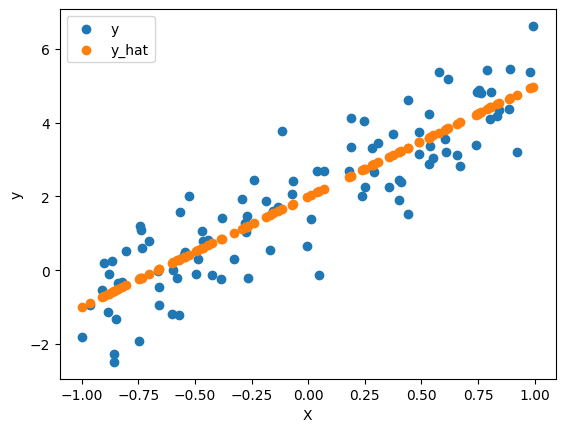

In [ ]:
size = 100
X = torch.ones(size, 2)
X[:, 0].uniform_(-1., 1)

y_hat = 3 * X[:, 0] + 2
y = y_hat + torch.randn(size)

loss_animator = LossAnimator(X, y)

plt.scatter(loss_animator.X[:,0], loss_animator.y, label='y');
plt.scatter(loss_animator.X[:,0], y_hat, label='y_hat');
plt.xlabel('X')
plt.ylabel('y')
plt.legend()

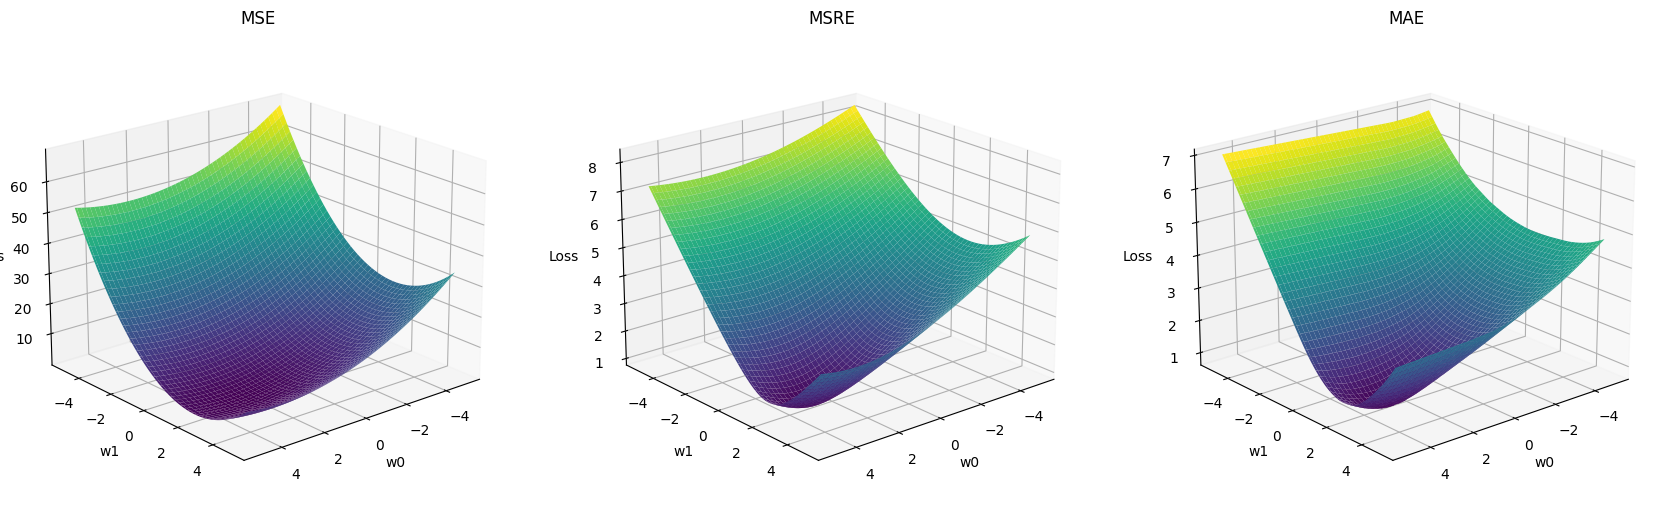

In [ ]:
weights = grid_samples()
loss_animator.plot_loss_funcs(weights, [mse, msre, mae], ['MSE', 'MSRE', 'MAE'])

In [ ]:
class Optimizer:
    def __init__(self, params):
        self.params = list(params)

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.detach_()
                param.grad.zero_()

    def pre_step(self):
        pass

    def step(self):
        pass

    def update_param(self, p):
        raise NotImplementedError()


In [ ]:
def optimize_function(fn, optim, optim_args, start_point, num_iter = 50):
    weigths = nn.Parameter(torch.FloatTensor(start_point), requires_grad=True)

    optim = optim(params=[weigths], **optim_args)
    points = []
    losses = []
    for i in range(num_iter):
        if hasattr(optim, 'pre_step'):
            optim.pre_step()
        loss = fn(weigths)
        points.append(weigths.data.detach().clone())
        losses.append(loss.item())
        loss.backward()
        optim.step()
        optim.zero_grad()
    points = torch.stack(points, axis=0)
    losses = torch.FloatTensor(losses)
    return points, losses


In [ ]:
def compare_optimizers(
    loss_animator,
    fn,
    optim_list,
    start_point,
    num_iter = 50,
    step_skip = 1
):
    data = {}
    loss_func = partial(loss_animator.loss_func, loss=fn)
    for name, optim, args in optim_list:
        points, losses = optimize_function(loss_func, optim, args, start_point, num_iter)
        data[name] = {
            'weights': points,
            'losses': losses,
        }

    return loss_animator.animate(num_iter, data, step_skip=step_skip)

Реализация методов SGD и AdaGrad с семинара:

In [ ]:
class SGD(Optimizer):
    def __init__(self, params, lr=1e-2):
        super().__init__(params)
        self.lr = lr

    def step(self):
        with torch.no_grad():
            for p in self.params:
                if p.grad is None:
                    continue
                p -= self.lr * p.grad

In [ ]:
class AdaGrad(Optimizer):
    def __init__(self, params, epsilon=1e-8, eta=1e-2):
        super().__init__(params)
        self.epsilon = epsilon
        self.eta = eta

        self.G = [0] * len(self.params)

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue

                self.G[i] += p.grad ** 2

                p -= self.eta / torch.sqrt(self.G[i] + self.epsilon) * p.grad

### 1.1 Реализуйте методы Momentum, AdaDelta, Adam. **(1 балл)**

#### Momentum
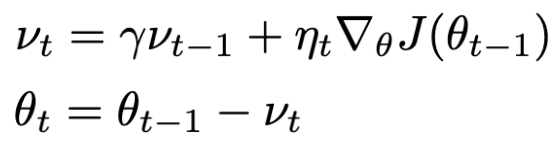

In [ ]:
class Momentum(Optimizer):
    def __init__(self, params, lr=1e-2, gamma=0.9):
        super().__init__(params)
        self.lr = lr
        self.gamma = gamma

        self.momentum = [torch.zeros_like(p) for p in self.params]


    def step(self):
      with torch.no_grad():
          for i, p in enumerate(self.params):
              if p.grad is None:
                  continue

              self.momentum[i] = self.gamma * self.momentum[i] + self.lr * p.grad
              p -= self.momentum[i]

#### AdaDelta
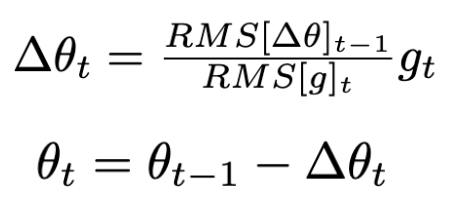

In [ ]:
class AdaDelta(Optimizer):
    def __init__(self, params, epsilon=1e-8, gamma=0.9, init_params=1e-2):
        super().__init__(params)
        self.epsilon = epsilon
        self.gamma = gamma

        self.G = [torch.zeros_like(p) for p in self.params]
        self.delta_p_exp_mean_prev = [torch.full_like(p, init_params) for p in self.params]

    def step(self):
      with torch.no_grad():
        for i, p in enumerate(self.params):
          if p.grad is None:
            continue

          self.G[i] = self.gamma * self.G[i] + (1 - self.gamma) * (p.grad ** 2)
          delta_p = torch.sqrt((self.delta_p_exp_mean_prev[i] + self.epsilon) / (self.G[i] + self.epsilon)) * p.grad
          p -= delta_p
          self.delta_p_exp_mean_prev[i] = self.gamma * self.delta_p_exp_mean_prev[i] + (1 - self.gamma) * (delta_p ** 2)

#### Adam
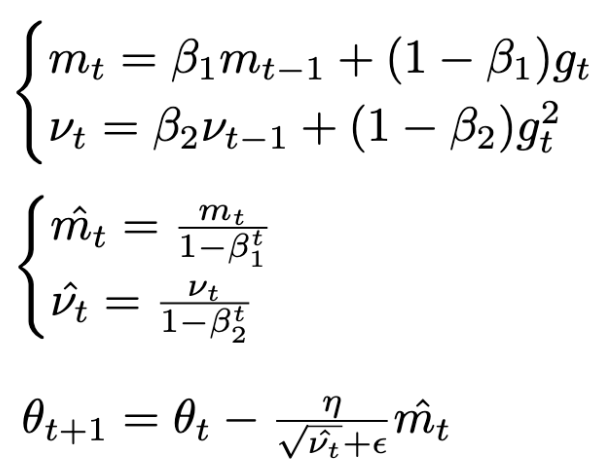

In [ ]:
class Adam(Optimizer):
    def __init__(self, params, b1=0.9, b2=0.999, lr=1e-2, epsilon=1e-8):
        super().__init__(params)
        self.lr = lr
        self.epsilon = epsilon

        self.b1 = b1
        self.b2 = b2

        self.m1 = [torch.zeros_like(p) for p in self.params]
        self.m2 = [torch.zeros_like(p) for p in self.params]

        self.t = 0

    def step(self):
        self.t += 1

        with torch.no_grad():
          for i, p in enumerate(self.params):
            if p.grad is None:
              continue

            self.m1[i] = self.b1 * self.m1[i] + (1 - self.b1) * p.grad
            self.m2[i] = self.b2 * self.m2[i] + (1 - self.b2) * (p.grad ** 2)

            m1_unbiased = self.m1[i] / (1 - self.b1 ** self.t)
            m2_unbiased = self.m2[i] / (1 - self.b2 ** self.t)

            p -= self.lr / (torch.sqrt(m2_unbiased) + self.epsilon) * m1_unbiased

### 1.2 Сравните реализованные методы на предложенном примере **(1 балл)**

In [ ]:
from functools import partial

points, losses = optimize_function(partial(loss_animator.loss_func, loss=mse), AdaDelta, {}, start_point=[-4, -4], num_iter=100)

In [ ]:
compare_optimizers(
    loss_animator,
    mse,
    [
        ['SGD', SGD, {'lr': 1e-1}],
        ['Momentum', Momentum, {'lr': 1e-2}],
        ['AdaGrad', AdaGrad, {'eta': 1}],
        ['AdaDelta', AdaDelta, {'gamma': 0.999}],
        ['Adam', Adam, {'lr': 0.5}],
     ],
    start_point=[-4, -4],
    num_iter=100
)

Таким образом, получили:
1. SGD сходится не очень быстро, в начале движения отклоняется от оптимальной траектории, т.к. встречает локальные минимумы
2. AdaGrad сходится по оптимальной траектории сразу, однако в конце пути замедляется из-за накопления градиента (знаменатель формулы), сходится чуть медленнее SGD
3. Momentum совершает петли, отклоняясь от оптимальной траектории, т.к сохраняет инерцию, сходится чуть медленнее SGD
4. AdaDelta сходится быстрее всего по оптимальной траектории, т.к. помимо корректировки с помощью учёта эксп. среднего градиента, учитывает информацию о предыдущих изменениях параметров
5. Adam имеет отклонения в траектории благодаря моментуму, однако также стабильно сходится, но не так быстро как AdaDelta.

##  Часть 2: Обучение нейронной сети

### 2.1 Реализуйте сверточную нейронную сеть и обучите ее на MNIST с помощью методов Adam, Adagrad, AdaDelta и SGD. Для обучения используйте оптимизаторы из первой части, а не из pytorch. **(2 балла)**

Скачайте датасет и реализуйте даталоудеры:

In [ ]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

--2024-10-27 11:01:48--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2024-10-27 11:01:48--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz’

MNIST.tar.gz            [        <=>         ]  33.20M  1.54MB/s    in 36s     

2024-10-27 11:02:25 (941 KB/s) - ‘MNIST.tar.gz’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw/trai

In [ ]:
transform = transforms.Compose([
   transforms.ToTensor(),
   transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('.', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('.', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

Реализуйте сверточную нейронную нейронную сеть по шаблону:

* Используйте сверточные (nn.Conv2d) и полносвязные (nn.Linear) слои
* Не забудьте преобразовать тензор перед подачей в полносвязный слой (x = x.view(-1, d1), где d1 -- размерность входа первого полносвязного слоя)
* Можно использовать dropout (nn.Dropout2d) и функции активации (например, F.relu)
* В конце метода forward необходимо использовать F.log_softmax для предсказания класса изображения

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.dropout = nn.Dropout2d(p=0.25)

        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)

        x = x.view(-1, 64 * 7 * 7)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)

In [ ]:
network = Net()
optimizers = {
    'Adam': Adam(network.parameters(), lr=1e-3),
    'AdaGrad': AdaGrad(network.parameters(), eta=1e-2),
    'AdaDelta': AdaDelta(network.parameters(), init_params=1e-8, gamma=0.999),
    'SGD': SGD(network.parameters(), lr=1e-1)
}

Запустите обучение, постройте график лоссов от эпохи:

In [ ]:
losses_dict = {}
for optimizer_name, optimizer in optimizers.items():
  print(f'\nOptimizer: {optimizer_name}')
  losses = []
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
      optimizer.zero_grad()
      output = network(data)
      loss = F.nll_loss(output, target)
      loss.backward()
      optimizer.step()


      if batch_idx % 100 == 0:
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          1, batch_idx * len(data), len(train_loader.dataset),
          100. * batch_idx / len(train_loader), loss.item()))
          losses.append(loss.item())

      losses_dict[optimizer_name] = losses


Optimizer: Adam
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.301407
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.347776
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.215065
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.133763
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.183657
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.013372
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.068582
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.070542
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.008377
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.060253
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.212765
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.201542
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.031783
Train Epoch: 1 [41600/60000 (69%)]	Loss: 0.008623
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.007486
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.082296
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.020002
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.009917
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.018509

Optimizer: AdaGrad
Train Epoch: 1 [0/6000

### 2.2 Сравните графики обучения для нейросети на методах Adam, Adagrad, AdaDelta и SGD. **(1 балл)**

---



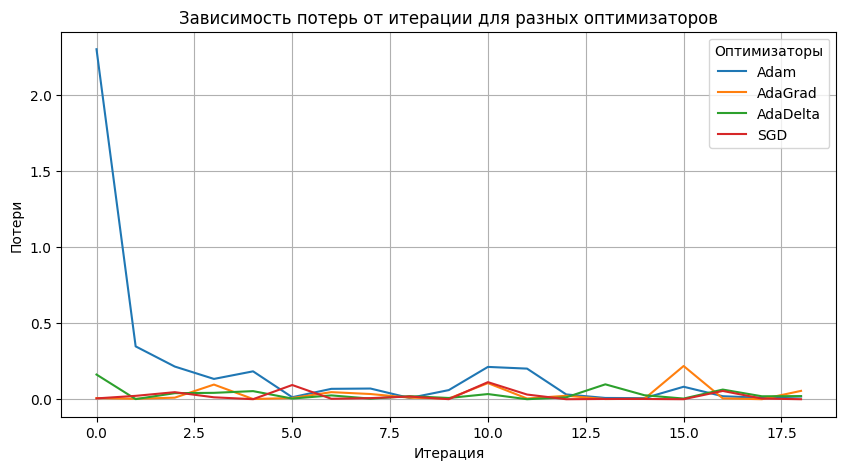

In [ ]:
# Построение графика

plt.figure(figsize=(10, 5))
for optimizer_name, losses in losses_dict.items():
    plt.plot(losses, label=optimizer_name)

plt.xlabel('Итерация')
plt.ylabel('Потери')
plt.title('Зависимость потерь от итерации для разных оптимизаторов')
plt.legend(title="Оптимизаторы")
plt.grid(True)
plt.show()

На датасете MNIST получили следующие результаты:
1. Adam начинает из неоптимальной точки, но довольно быстро устремляется к оптимуму, по пути совершая некоторые колебания из-за моментума
2. AdaGrad, AdaDelta, SGD сходятся практически сразу же, совершая небольшие колебания около оптимума